# Augur for Influenza A - HA protein

## Import packages

In [2]:
from Bio import Phylo
import matplotlib
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.Seq import translate
import re
import pandas as pd

## Configuration variables

In [33]:
subsample = 5
print("test for %s" %subsample)

test for 5


## Metadata is required -- Piece metadata file together

In [18]:
## Metadata is required

# Making metadata by parsing FASTA


records = []
for record in SeqIO.parse("../data/fluHA_sequences-with-metadata.fasta", "fasta"):
    records.append(record.description)

    
# Split description
split = []
for record in records:
    split.append(record.split('|'))

# Grab metadata from split description    
strainsList = []
idList = []
dateUnsplit = []
countryList = []
stateList = []
for item in split:
    strainsList.append(item[0])
    idList.append(item[1])
    dateUnsplit.append(item[2])
    countryList.append(item[3])
    stateList.append(item[4])

### Get dates from fasta.description

In [19]:
# Get dates
dateSearch = re.compile('(?P<month>\d{2})[/](?P<day>\d{2})[/](?P<year>\d{4}$)')
yearSearch = re.compile('(?P<year>\d{4}$)')
monthYearSearch = re.compile('(?P<month>\d{2})[/](?P<year>\d{4}$)')
monthList = []
dayList = []
yearList = []
for item in dateUnsplit:
    if len(item) == 4:
        y = yearSearch.search(item)
        year = y.group('year')
        yearList.append(year)
        monthList.append('XX')
        dayList.append('XX')
    elif len(item) == 10:
        d = dateSearch.search(item)
        month = d.group('month')
        day = d.group('day')
        year = d.group('year')
    
        monthList.append(month)
        dayList.append(day)
        yearList.append(year)
    elif len(item) == 7:
        d = monthYearSearch.search(item)
        month = d.group('month')
        year = d.group('year')
    
        monthList.append(month)
        dayList.append("XX")
        yearList.append(year)

        
# If year < 1957 add 19 years
index = 0
for year in yearList:
    if int(year) < 1976:
        yearList[index] = str(int(year) + 23)
    index += 1
        
dateList = []
index = 0
for i in range(len(dateUnsplit)):
    dateList.append(yearList[i] + '-' + monthList[i] + '-' + dayList[i])
    index += 1

### Combine ID and strains to create unique identifiers

In [20]:
# Concatenate strain strings with id strings for unique identifiers
newID = []
counter = 0
for id in idList:
    newID.append(id + "|" + strainsList[counter])
    
#     Remove spaces
#     if " " in newID[counter]:
#         newID[counter] = newID[counter].replace(" ", "")
#     counter += 1

# Remove apostrophes
    if "'" in newID[counter]:
        newID[counter] = newID[counter].replace("'", "")
    counter += 1



### Create new fasta file to replace IDs with the new ones

In [25]:
original_file = r"../data/fluHA_sequences-with-metadata.fasta"
corrected_file = r"../data/corrected2.fasta"

position = 0
with open(original_file) as original, open(corrected_file, 'w') as corrected:
    records = SeqIO.parse(original_file, 'fasta')
    for record in records:
#         print(record.id)
        record.id = newID[position]
        record.description = newID[position]
        position += 1
#         print(record.id)             
        SeqIO.write(record, corrected, 'fasta')

### Write metadata.tsv file

In [20]:
# metadata_id = list(zip(fasta_ids, strainsList, yearsList))
# metadata = list(zip(idList, strainsList, yearsList))
metadata = list(zip(newID, dateList))

# df = pd.DataFrame(data = metadata, columns=['id', 'strain', 'year'])
df = pd.DataFrame(data = metadata, columns=['strain', 'date'])

df.to_csv('../data/metadata.tsv',sep='\t',index=False,header=True)

## Tree with 5 sequences per group
### Filter

In [14]:
!mkdir -p ../results/

!augur filter \
  --sequences ../data/corrected.fasta \
  --metadata ../data/metadata.tsv \
  --exclude ../config/dropped_strains.txt \
  --output ../results/filtered-5.fasta \
  --group-by year \
  --sequences-per-group 5 \
  --min-date 1918

### Align

In [15]:
!augur align \
  --sequences ../results/filtered-5.fasta \
  --output ../results/aligned-5.fasta 


using mafft to align via:
	mafft --reorder --anysymbol --thread 1 ../results/filtered-5.fasta 1> ../results/aligned-5.fasta 2> ../results/aligned-5.fasta.log 

	Katoh et al, Nucleic Acid Research, vol 30, issue 14
	https://doi.org/10.1093%2Fnar%2Fgkf436



Tree takes 2.04 seconds to build

### Tree

#### Remove putative frameshifted alignments
**NOTE**: strain 'CY020461|A/Iowa/1943', "CY125196|A/Canada/591/2004", "CY146769|A/Bellamy/JY2/1942", "FJ231763|A/Bremen/4/2005" because they look like there may have been a frameshift in the sequences when they were aligned. Bio.Seq's translate function read "C---" as "C--" and got confused 

In [94]:
original_file = r"../results/aligned-5.fasta"
removed_file = r"../results/aligned-5_removed.fasta"
remove_list = ['CY020461|A/Iowa/1943', "CY125862|A/Kw/1/1957", "CY146793|A/Denver/JY2/1957", "HE802059|A/WSN/1933" ]


with open(original_file) as original, open(removed_file, 'w') as removed:
    records = SeqIO.parse(original_file, 'fasta')
    for record in records:
        if record.id not in remove_list:          
            SeqIO.write(record, removed, 'fasta')
            



In [95]:
!augur tree \
  --alignment ../results/aligned-5_removed.fasta \
  --output ../results/tree_raw-5_removed.nwk

Building a tree via:
	iqtree -ninit 2 -n 2 -me 0.05 -nt 1 -s ../results/aligned-5_removed-delim.fasta -m GTR > ../results/aligned-5_removed-delim.iqtree.log
	Nguyen et al: IQ-TREE: A fast and effective stochastic algorithm for estimating maximum likelihood phylogenies.
	Mol. Biol. Evol., 32:268-274. https://doi.org/10.1093/molbev/msu300

Building original tree took 1.4106712341308594 seconds


### View

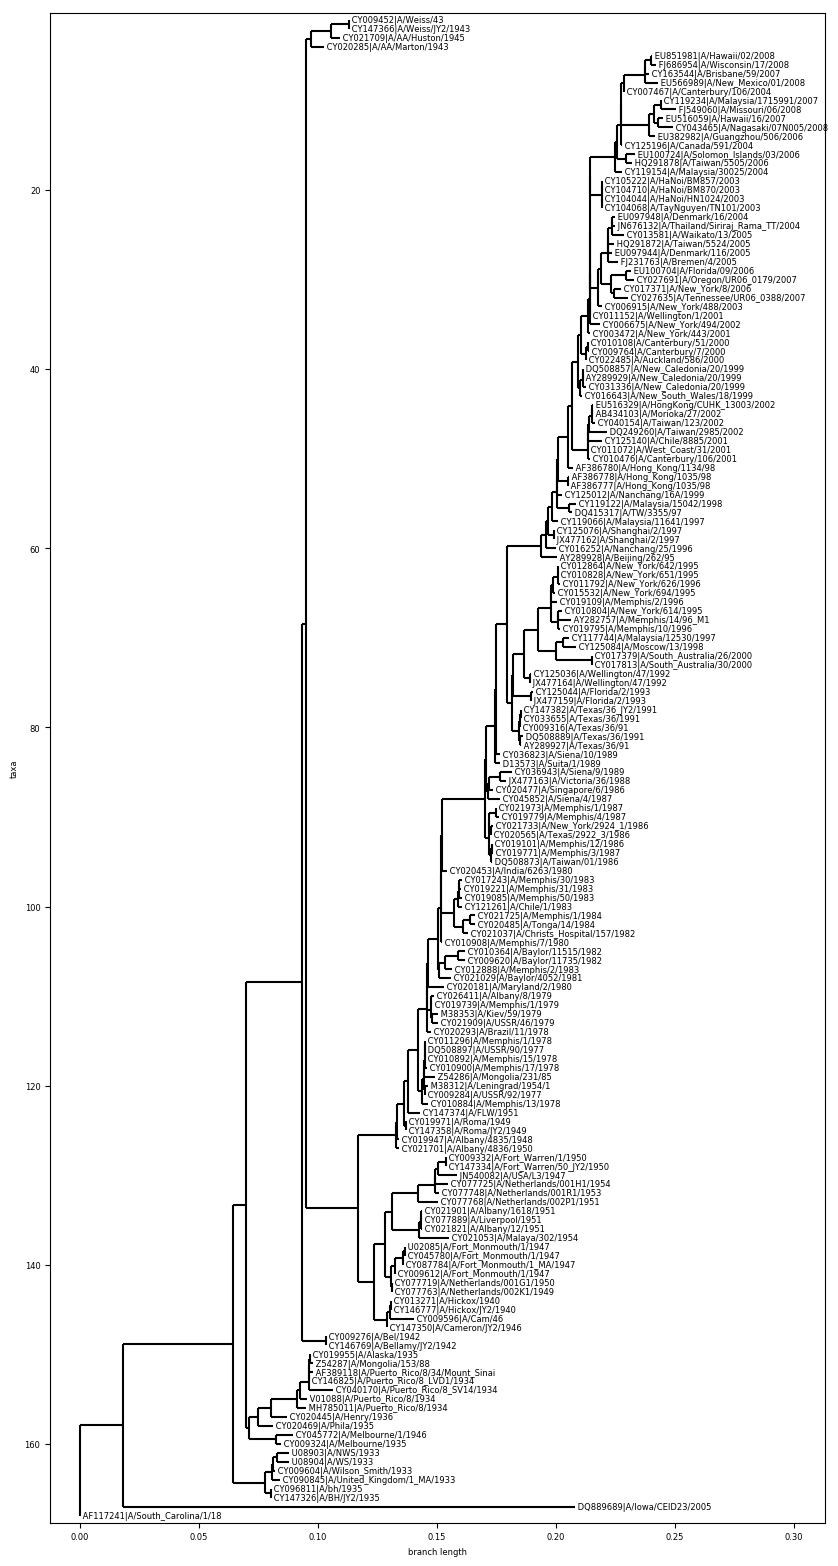

None


In [96]:
tree = Phylo.read("../results/tree_raw-5_removed.nwk", "newick")
matplotlib.rc('font',size=6)
fig = plt.figure(figsize=(10,20), dpi=100)
axes=fig.add_subplot(1, 1, 1)
tree.ladderize(reverse=True)
tree.root_with_outgroup(outgroup_targets="AF117241|A/South_Carolina/1/18")
print(Phylo.draw(tree, axes=axes))

### Count tips

Same number of tips as sequences

In [35]:
tree.count_terminals()

168

In [38]:
seqCount = []
for record in SeqIO.parse("../results/aligned-5_removed.fasta", "fasta"):
    seqCount.append(record.seq)

print(len(seqCount))

168


## Get time-resolved tree
### Augur refine

In [101]:
!augur refine \
  --tree ../results/tree_raw-5_removed.nwk \
  --alignment ../results/aligned-5_removed.fasta \
  --metadata ../data/metadata.tsv \
  --output-tree ../results/tree-5_removed.nwk \
  --output-node-data ../results/branch_lengths-5_removed.json \
  --timetree \
  --coalescent opt \
  --date-confidence \
  --date-inference joint
#   --clock-filter-iqd 4


4.94	###TreeTime.run: INITIAL ROUND

28.57	###TreeTime.run: ITERATION 1 out of 2 iterations

60.49	###TreeTime.run: ITERATION 2 out of 2 iterations

197.47	###TreeTime.run: FINAL ROUND - confidence estimation via marginal reconstruction

Inferred a time resolved phylogeny using TreeTime:
	Sagulenko et al. TreeTime: Maximum-likelihood phylodynamic analysis
	Virus Evolution, vol 4, https://academic.oup.com/ve/article/4/1/vex042/4794731

updated tree written to ../results/tree-5_removed.nwk
node attributes written to ../results/branch_lengths-5_removed.json


### View

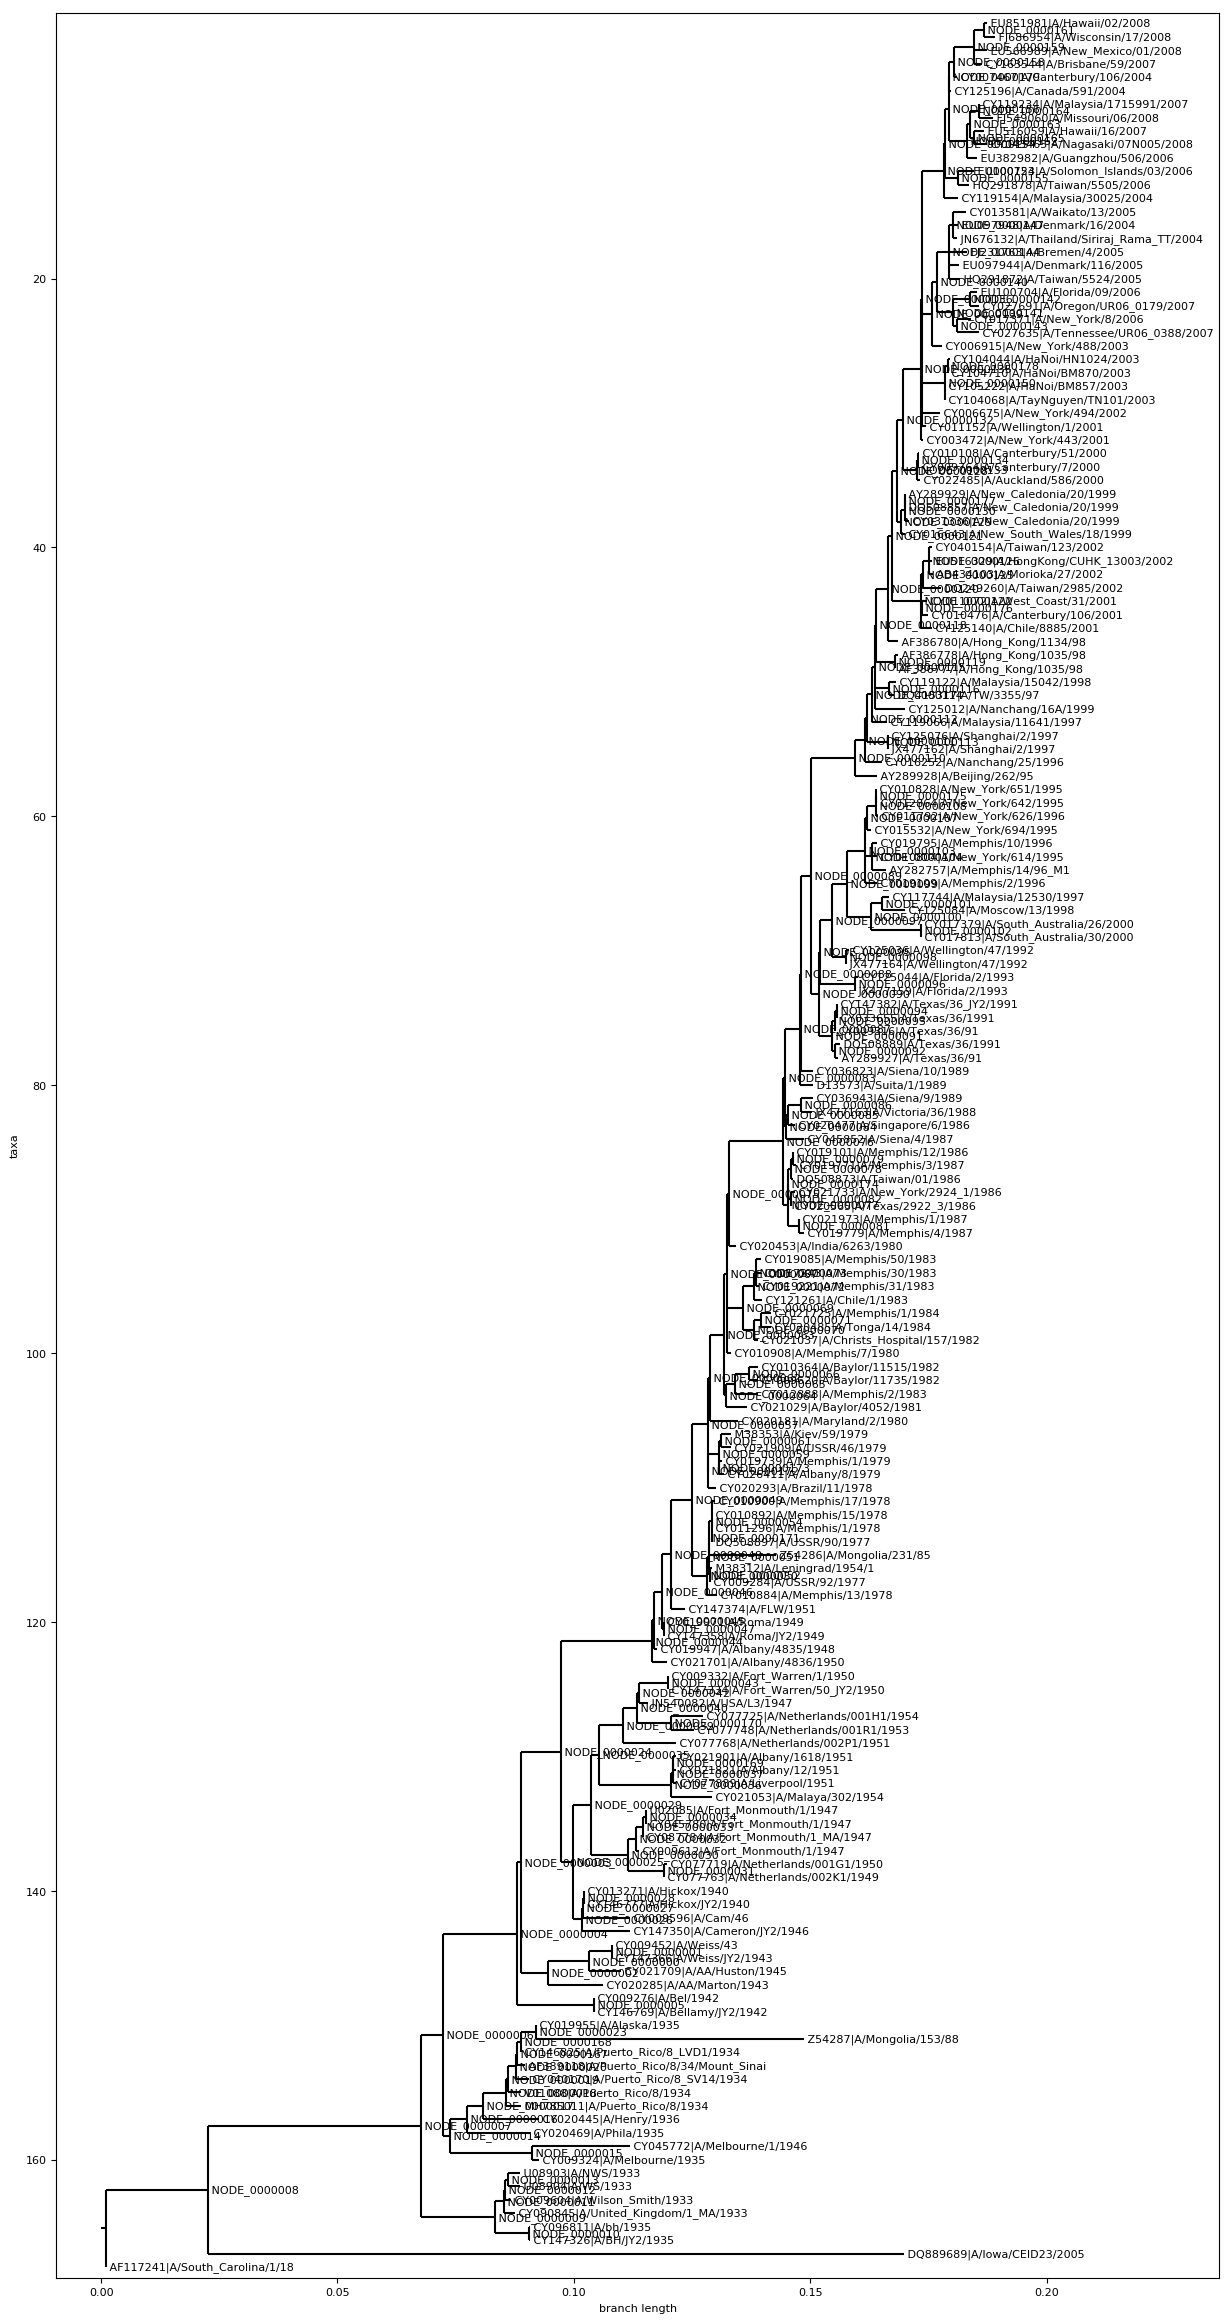

None


In [139]:
tree = Phylo.read("../results/tree-5_removed.nwk", "newick")
matplotlib.rc('font',size=8)
fig = plt.figure(figsize=(15,30), dpi=100)
axes=fig.add_subplot(1,1,1)
tree.ladderize(reverse=True)
tree.root_with_outgroup(outgroup_targets="AF117241|A/South_Carolina/1/18")
print(Phylo.draw(tree, axes=axes))

## Infer ancestral sequences

In [105]:
!augur ancestral \
  --tree ../results/tree-5_removed.nwk \
  --alignment ../results/aligned-5_removed.fasta \
  --output ../results/nt_muts-5_removed.json \
  --inference joint


Inferred ancestral sequence states using TreeTime:
	Sagulenko et al. TreeTime: Maximum-likelihood phylodynamic analysis
	Virus Evolution, vol 4, https://academic.oup.com/ve/article/4/1/vex042/4794731

ancestral sequences written to ../results/nt_muts-5_removed.json


## Identify amino acid mutations

### Translate NTs to AAs

In [179]:

import json

# Get names and sequences from nt_muts-5.json

with open("../results/nt_muts-5_removed.json") as nt:
    nt_muts = json.load(nt)

strains = []
nt_seqs = []
for strain in nt_muts['nodes'].keys():
    strains.append(strain)
    
    # seqs as strings
    nt_seqs.append(nt_muts['nodes'][strain]['sequence'])
    
    # seqs as Seq object
#     nt_seqs.append(Seq(nt_muts['nodes'][strain]['sequence']))



# Remove problematic sequences
# These were removed in the "removed" fasta file above
# del nt_seqs[65]
# del strains[65]

# del nt_seqs[119]
# del strains[119]

# del nt_seqs[120]
# del strains[120]

# del nt_seqs[148]
# del strains[148]

# del nt_seqs[122]
# del strains[122]

# del nt_seqs[151]
# del strains[151]

# del nt_seqs[200]
# del strains[120]



# This one is a NODE...
# del nt_seqs[205]
# del strains[205]

aa_seqs = []
counter = 0
for seq in nt_seqs:
    aa_seqs.append(translate(seq, gap='-'))
    counter += 1
    
aa_strains = list(zip(strains, aa_seqs))

# Working with seqs as strings
# translate(nt_seqs[5], gap = '-')

# Working with seqs as Seq object
# nt_seqs[65].translate(gap='-')
# nt_seqs[65]

# aa_strains[65]

# aa_seqs
# aa_strains
# nt_seqs
# aa_muts

aa_strains_df = pd.DataFrame(data = aa_strains, columns=['strains', 'aa_seqs'], index = None)



In [107]:
# Find problematic strains
print(counter)

print(strains[counter])

65
CY020461|A/Iowa/1943


In [159]:
aa_strains_df

,strains,aa_seqs
0,AB434103|A/Morioka/27/2002,MKAKLLVLLCTFTATYADTICIGYHANNSTDTVDTVLEKNVTVTHS...
1,AF117241|A/South_Carolina/1/18,MEARLLVLLCAFAATNADTICIGYHANNSTDTVDTVLEKNVTVTHS...
2,AF386777|A/Hong_Kong/1035/98,MKAKLLVLLCTFTATYADTICIGYHANNSTDTVDTVLEKNVTVTHS...
3,AF386778|A/Hong_Kong/1035/98,MKAKLLVLLCTFTATYADTICIGYHANNSTDTVDTVLEKNVTVTHS...
4,AF386780|A/Hong_Kong/1134/98,MKAKLLVLLCTFTATYADTICIGYHANNSTDTVDTVLEKNVTVTHS...
5,AF389118|A/Puerto_Rico/8/34/Mount_Sinai,MKANLLVLLSALAAADADTICIGYHANNSTDTVDTVLEKNVTVTHS...
6,AY282757|A/Memphis/14/96_M1,MKAKLLVLLCAFTATYADTICIGYHANNSTDTVDTVLEKNVTVTHS...
7,AY289927|A/Texas/36/91,MKAKLLVLLCAFTATYADTICIGYHANNSTDTVDTVLEKNVTVTHS...
8,AY289928|A/Beijing/262/95,MKAKLLVLLCTFTATYADTICIGYHANNSTDTVDTVLEKNVTVTHS...
9,AY289929|A/New_Caledonia/20/1999,MKAKLLVLLCTFTATYADTICIGYHANNSTDTVDTVLEKNVTVTHS...


### Trace tree

In [ ]:
# for tip in tree, trace starting at tip and going to South_Carolina 1918 
tree = Phylo.read("../results/tree-5_removed.nwk", "newick")
traces = []
tips = []
for tip in tree.get_terminals():
    tips.append(tip)
    traces.append(tree.trace(start = tip, finish = "AF117241|A/South_Carolina/1/18"))
    
for trace in traces:
    for clade in trace:
        if clade.name == None:
            trace.remove(clade)

#### Cumulative distances from tip to root

In [129]:
tree = Phylo.read("../results/tree-5_removed.nwk", "newick")
paths = []
for tip in tree.get_terminals():
    paths.append(tree.get_path(tip))

# Reverse the direction of the paths
index = 0
for path in paths:
    paths[index] = path[::-1]
    index += 1
    
# Distance between 
branch_lengths = []
start_node = []
end_node = []
for tip in paths:
    for parent in tip:
        branch_lengths.append(tree.distance(target1 = tip[0].name, target2 = parent.name))
        start_node.append(tip[0].name)
        end_node.append(parent.name)


total_distances = list(zip(start_node, end_node, branch_lengths))

# df = pd.DataFrame(data = metadata, columns=['id', 'strain', 'year'])
dist_total = pd.DataFrame(data = total_distances, columns=['start_node', 'end_node', 'branch_lengths'])

dist_total


,start_node,end_node,branch_lengths
0,AF117241|A/South_Carolina/1/18,AF117241|A/South_Carolina/1/18,0.000000
1,AF117241|A/South_Carolina/1/18,NODE_0000008,0.021564
2,DQ889689|A/Iowa/CEID23/2005,DQ889689|A/Iowa/CEID23/2005,0.000000
3,DQ889689|A/Iowa/CEID23/2005,NODE_0000008,0.147314
4,CY096811|A/bh/1935,CY096811|A/bh/1935,0.000000
5,CY096811|A/bh/1935,NODE_0000010,0.000012
6,CY096811|A/bh/1935,NODE_0000009,0.007333
7,CY096811|A/bh/1935,NODE_0000007,0.022976
8,CY147326|A/BH/JY2/1935,CY147326|A/BH/JY2/1935,0.000000
9,CY147326|A/BH/JY2/1935,NODE_0000010,0.000012


#### Stepwise distances from tip to parent until root

In [197]:
# for tip in tree, trace starting at tip and going to South_Carolina 1918 
tree = Phylo.read("../results/tree-5_removed.nwk", "newick")
traces = []
tips = []
for tip in tree.get_terminals():
    tips.append(tip)
    traces.append(tree.trace(start = tip, finish = "AF117241|A/South_Carolina/1/18"))
    
for trace in traces:
    for clade in trace:
        if clade.name == None:
            trace.remove(clade)


start_node = []
end_node = []
branch_lengths = []
index = 0
for trace in traces:
    prev_node = tips[index].name
    for node in trace:
        branch_lengths.append(node.branch_length)
        start_node.append(prev_node)
        end_node.append(node.name)
        prev_node = node.name
    index += 1

# Pair strains to amino acid sequences in a dictionary
aa_strains_dict = {}
for key, value in aa_strains:
    aa_strains_dict[key] = value

# Compare sequences, store amino acid mutations in aa_muts list
aa_strains_dict
aa_muts = []
pos = 1
muts = []
for start, ref in zip(start_node, end_node):
    start_seq = aa_strains_dict[start]
    ref_seq = aa_strains_dict[ref]
    
    for aa1, aa2 in zip(start_seq, ref_seq):
        if aa1 == aa2:
#         print(aa1 + str(pos) + aa2)
            pos += 1
        if aa1 != aa2:
            muts.append(aa1 + str(pos) + aa2)
#         print(aa1 + str(pos) + aa2)
            pos += 1
    aa_muts.append(muts)
    muts = []
    pos = 1

stepwise_distances = list(zip(start_node,end_node, branch_lengths, aa_muts))
dist_stepwise = pd.DataFrame(data = stepwise_distances, columns=['start_node','end_node', 'branch_lengths', 'aa_muts'])
dist_stepwise.to_csv(r'../results/stepwise_mutations-5_removed.csv')

dist_stepwise

,start_node,end_node,branch_lengths,aa_muts
0,AF117241|A/South_Carolina/1/18,AF117241|A/South_Carolina/1/18,0.021564,[]
1,DQ889689|A/Iowa/CEID23/2005,NODE_0000008,0.006802,"[I4R, I5L, V6L, Y10C, T11A, T14A, A15T, L20I, ..."
2,NODE_0000008,AF117241|A/South_Carolina/1/18,0.021564,"[K2E, D16N, S86L, P100S, R130K, A137T, D144E, ..."
3,CY096811|A/bh/1935,NODE_0000010,0.007321,[]
4,NODE_0000010,NODE_0000009,0.015643,"[R156G, Q158K, R210H, M258I]"
5,NODE_0000009,NODE_0000007,0.038280,"[L36V, A106T, L128F, I146T, S152A, G156A, S201..."
6,NODE_0000007,NODE_0000166,0.001000,"[L12F, P89T, R91S, E137A, N144D, H155Y, K158A,..."
7,NODE_0000166,NODE_0000008,0.006802,[]
8,NODE_0000008,AF117241|A/South_Carolina/1/18,0.021564,"[K2E, D16N, S86L, P100S, R130K, A137T, D144E, ..."
9,CY147326|A/BH/JY2/1935,NODE_0000010,0.007321,[]
